# Methodology
1. Work of Ehrenberg-Bass Institute & Byron Sharp
2. EDA
3. Dirichlet Model
4. Duplication of Purchase
5. RFM Analysis
6. PCA & Cluster

# Assumption
Hypothsis: All unique customers in carboload dataset are the panel base for theoretical analysis.

In [84]:
!pip install pandas matplotlib seaborn
!pip install sqlalchemy
!pip install -U pip setuptools wheel
!pip install -U scikit-learn

In [137]:
import pandas as pd
import numpy as np
import sqlite3
import os
import seaborn  as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FuncFormatter

pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
%matplotlib inline

# 1) Data preparation

## STEP1: Build a solid SQL database with Dunnhumby Carboload csv files.

### 1. Create a combined table containing other three tables, such as dh_transactions, dh_product_lookup, and dh_causal_lookup.

In [86]:
# 1. CONNECT TO THE EXSITING DATABASE
DB_PATH = r"/Users/ying/25001197/assignment_2 copy/assignment_2_database.sqlite"
OUT_DIR = "/Users/ying/25001197/assignment_2 copy/outputs"
os.makedirs(OUT_DIR, exist_ok=True)
engine = create_engine(f"sqlite:///{DB_PATH}", future=True)

drop_sql = "DROP TABLE IF EXISTS total_carboload;"

sql_create_total = """

CREATE TABLE total_carboload AS
SELECT
    t.upc,
    t.store,
    t.week,
    t.household,
    t.basket,
    t.day,
    t.units,
    t.dollar_sales,
    t.coupon,
    p.product_description,
    p.commodity,
    p.brand,
    p.product_size,
    c.feature_desc,
    c.display_desc,
    c.geography AS causal_geography
FROM dh_transactions t
JOIN dh_product_lookup p
    ON t.upc = p.upc
LEFT JOIN dh_causal_lookup c
    ON t.upc = c.upc
   AND t.store = c.store
   AND t.week = c.week;
"""

with engine.begin() as conn:
    conn.execute(text(drop_sql))
    conn.execute(text(sql_create_total))
print("total_carboload has been created successfully")


total_carboload has been created successfully


### 2. READ THE TOTAL RAWDATA FROM DATABASE

In [87]:
with engine.begin() as conn:
    total_carboload = pd.read_sql("SELECT * FROM total_carboload;", conn)

total_carboload.to_csv("/Users/ying/25001197/assignment_2 copy/outputs/total_carboload.csv")
total_carboload.head()

,upc,store,week,household,basket,day,units,dollar_sales,coupon,product_description,commodity,brand,product_size,feature_desc,display_desc,causal_geography
0,7680850106,244,1,125434,1,1,1,0.80,0,BARILLA ANGEL HAIR,pasta,Barilla,16 OZ,None,None,NaN
1,3620000470,244,1,125434,1,1,1,3.59,0,BERTOLLI TOM&BASIL SAUCE,pasta sauce,Bertolli,24 OZ,None,None,NaN
2,1800028064,244,1,108320,2,1,1,2.25,0,H J PANCK BTRMLK COMP MIX,pancake mixes,Hungry Jack,None,None,None,NaN
3,9999985067,244,1,162016,3,1,1,0.85,0,PRIVATE LABEL VERMICELLI,pasta,Private Label,16 OZ,None,None,NaN
4,9999985131,244,1,89437,4,1,1,2.19,0,PRIVATE LABEL IMPORTED LASAGNA,pasta,Private Label Premium,16 OZ,None,None,NaN


## Step2. Write an SQL query to extract and save a .csv file containing "pasta" data.

In [88]:
sql_pasta = """
SELECT
    upc,
    week,
    day,
    brand,
    household,
    basket,
    units,
    dollar_sales
from total_carboload
where commodity = "pasta"
"""
with engine.begin() as conn:
    df_pasta = pd.read_sql(text(sql_pasta), conn)
df_pasta.head()

,upc,week,day,brand,household,basket,units,dollar_sales
0,7680850106,1,1,Barilla,125434,1,1,0.80
1,9999985067,1,1,Private Label,162016,3,1,0.85
2,9999985131,1,1,Private Label Premium,89437,4,1,2.19
3,9999985051,1,1,Private Label,158549,5,1,1.29
4,9999985053,1,1,Private Label Premium,18851,6,1,0.75


## Step3. Data cleaning (Use Python and Jupyter notebooks to clean the data (watch out for partial time periods!).)

### 1. check data structure and examine if the pasta dataset have missing values or outliers

In [89]:
print(df_pasta.info())  # correct datatypes
print("the number of missing values:",df_pasta.isnull().sum())  # no missing value
print("Duplicates:",df_pasta.duplicated().sum())  # no duplicate
print(df_pasta.describe())  # there is something wrong with "dollar_sales" because the min of it is below zero which seems impossible

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327944 entries, 0 to 2327943
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   upc           int64  
 1   week          int64  
 2   day           int64  
 3   brand         object 
 4   household     int64  
 5   basket        int64  
 6   units         int64  
 7   dollar_sales  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 142.1+ MB
None
the number of missing values: upc             0
week            0
day             0
brand           0
household       0
basket          0
units           0
dollar_sales    0
dtype: int64
Duplicates: 0
                upc          week           day     household        basket         units  dollar_sales
count  2.327944e+06  2.327944e+06  2.327944e+06  2.327944e+06  2.327944e+06  2.327944e+06  2.327944e+06
mean   7.611714e+09  5.308000e+01  3.685183e+02  2.212917e+05  1.659330e+06  1.237503e+00  1.225086e+00
std    3.058745e+09  3.006523e+01  2

In [90]:
# filter and get the cleaned pasta data
df_pasta = df_pasta[df_pasta["dollar_sales"]>=0]
df_pasta.to_csv(r"/Users/ying/25001197/assignment_2 copy/outputs/df_pasta.csv", index=False)
df_pasta.head()

,upc,week,day,brand,household,basket,units,dollar_sales
0,7680850106,1,1,Barilla,125434,1,1,0.80
1,9999985067,1,1,Private Label,162016,3,1,0.85
2,9999985131,1,1,Private Label Premium,89437,4,1,2.19
3,9999985051,1,1,Private Label,158549,5,1,1.29
4,9999985053,1,1,Private Label Premium,18851,6,1,0.75


### 2. check whether the time periods are successive or not 

In [91]:
weeks = sorted(df_pasta["week"].unique())
print("min weeks:", weeks[0])
print("max weeks:", weeks[-1])
print("total weeks:", len(weeks))
print("theoretical weeks:", weeks[-1] - weeks[0] + 1)

if len(weeks) == weeks[-1] - weeks[0] + 1:
    print("week is consecutive")
else:
    print("week is not consecutive") # weeks are consecutive in pasta dataset

min weeks: 1
max weeks: 104
total weeks: 104
theoretical weeks: 104
week is consecutive


### 3. Check partial time periods and mark them if exist.

visualize if partial time periods exist, which can really affect the outcome of analysis, create df_pasta_week_days and plot the partial weeks, obviously we can see that the graph shows that partial time periods actually exist, they are week 23 and week 75.

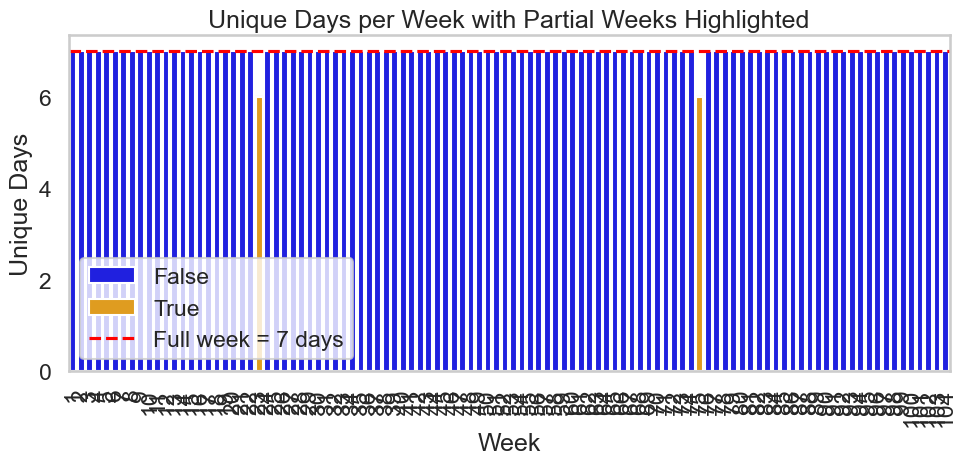

In [92]:
# Count unique days per week
df_pasta_week_days = (
    df_pasta.groupby("week")["day"]
      .nunique()
      .reset_index()
      .rename(columns={"day": "unique_days"})
)

# Mark partial weeks (< 7 days)
df_pasta_week_days["is_partial"] = df_pasta_week_days["unique_days"] < 7

plt.figure(figsize=(10, 5))

sns.barplot(
    data=df_pasta_week_days,
    x="week",
    y="unique_days",
    hue="is_partial",
    dodge=False,
    palette={True: "orange", False: "blue"}
)

plt.axhline(7, color="red", linestyle="--", label="Full week = 7 days")
plt.xticks(rotation=90)
plt.xlabel("Week")
plt.ylabel("Unique Days")
plt.title("Unique Days per Week with Partial Weeks Highlighted")
plt.legend()
plt.tight_layout()
plt.show() # week 23 and week 75 are not full weeks, whereas other weeks are all full.

### 4. EDA

In [93]:
# ensure numeric
df_pasta["dollar_sales"] = pd.to_numeric(df_pasta["dollar_sales"], errors="coerce")
df_pasta["units"] = pd.to_numeric(df_pasta["units"], errors="coerce")

# brand-level unit price, broadcast back to rows
brand_sales = df_pasta.groupby("brand")["dollar_sales"].transform("sum")
brand_units = df_pasta.groupby("brand")["units"].transform("sum")

df_pasta["unit_price"] = brand_sales / brand_units
df_pasta.loc[~brand_units.gt(0), "unit_price"] = pd.NA  # guard against divide-by-zero
df_pasta

,upc,week,day,brand,household,basket,units,dollar_sales,unit_price
0,7680850106,1,1,Barilla,125434,1,1,0.80,1.102037
1,9999985067,1,1,Private Label,162016,3,1,0.85,0.784337
2,9999985131,1,1,Private Label Premium,89437,4,1,2.19,1.001278
3,9999985051,1,1,Private Label,158549,5,1,1.29,0.784337
4,9999985053,1,1,Private Label Premium,18851,6,1,0.75,1.001278
...,...,...,...,...,...,...,...,...,...
2327939,7151800024,104,728,Hodgson Mills,429812,3316340,1,1.59,1.817276
2327940,9999985001,104,728,Private Label,209850,3316341,1,0.39,0.784337
2327941,9999985001,104,728,Private Label,435465,3316346,1,0.39,0.784337
2327942,9999985027,104,728,Private Label,352690,3316347,1,0.99,0.784337


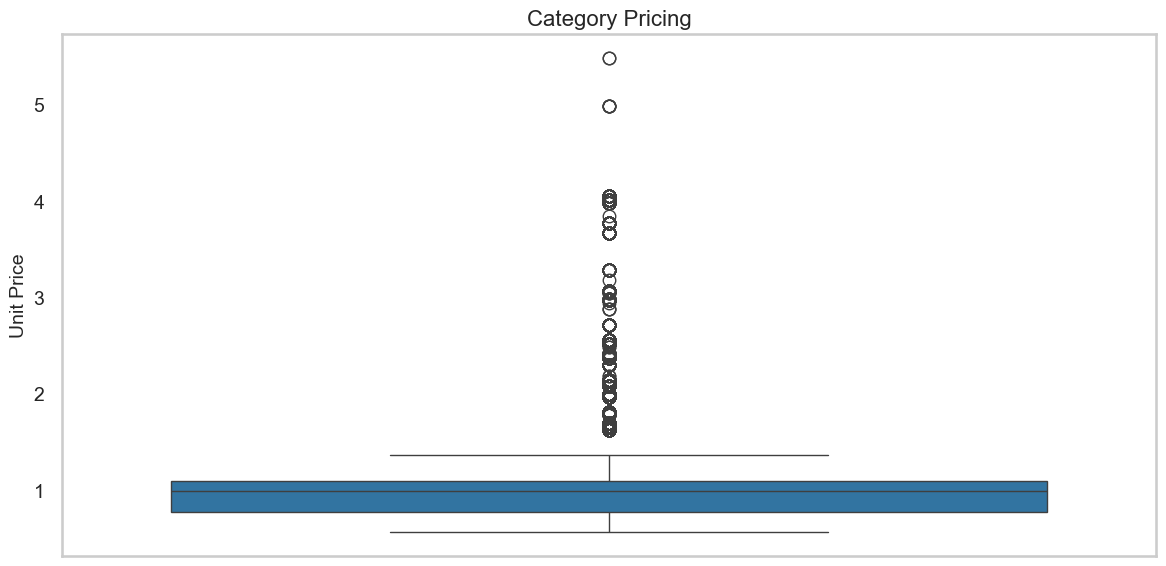

In [94]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_pasta,y="unit_price")
plt.title("Category Pricing", fontsize=16)
plt.ylabel("Unit Price", fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid(False)
plt.savefig("/Users/ying/25001197/assignment_2 copy/outputs/figs/Category Pricing.png", dpi=300, bbox_inches="tight")
plt.show()

# 2) Category dashboard

## 2.1 Category KPIs per quarter/week (drill if needed)

total_pasta_buyers:  411502
total_pasta_transactions:  1959963
total_pasta_units:  2877767
total_pasta_revenue:  2852543.71
Category purchase frequency W: 4.762948904258059
   quarter  quarter_revenue  quarter_units  quarter_transactions  quarter_buyers
0        1        351531.55         353851                240167          137404
1        2        368235.29         350925                249890          141822
2        3        349341.68         350412                241644          138101
3        4        312454.34         316488                217567          128278
4        5        357253.45         356838                246161          141987
5        6        390429.49         388348                264182          149299
6        7        373448.65         397880                260395          147216
7        8        349849.26         363025                239957          139204


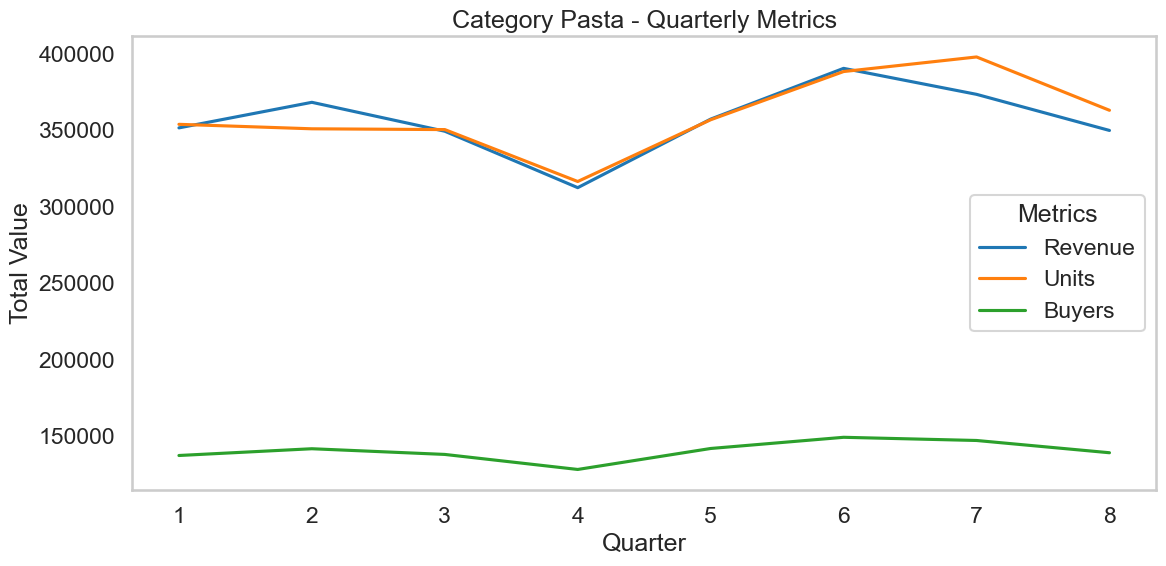

In [95]:
# Category-level KPIs

# Category buyers
total_pasta_buyers = df_pasta["household"].nunique()
total_pasta_transactions = df_pasta["basket"].nunique()
total_pasta_units = df_pasta["units"].sum()
total_pasta_revenue = df_pasta["dollar_sales"].sum()
purchase_fre_W = total_pasta_transactions / total_pasta_buyers

print("total_pasta_buyers: ", total_pasta_buyers)
print("total_pasta_transactions: ", total_pasta_transactions)
print("total_pasta_units: ", total_pasta_units)
print("total_pasta_revenue: ", total_pasta_revenue)
print("Category purchase frequency W:",purchase_fre_W)

# Category quarterly overview (PASTA total)
# Step 1: Add quarter column
df_pasta['quarter'] = ((df_pasta['week'] - 1) // 13) + 1
quarters = sorted(df_pasta['quarter'].unique())

quarter_metrics = df_pasta.groupby("quarter", as_index=False).agg(
    quarter_revenue=("dollar_sales","sum"),
    quarter_units=("units","sum"),
    quarter_transactions=("basket","nunique"),
    quarter_buyers=("household","nunique")
)
quarter_metrics.to_csv("/Users/ying/25001197/assignment_2 copy/outputs/quarter_metrics.csv")
print(quarter_metrics)

plt.figure(figsize=(12,6))
sns.lineplot(data=quarter_metrics, x="quarter", y="quarter_revenue", label="Revenue")
sns.lineplot(data=quarter_metrics, x="quarter", y="quarter_units", label="Units")
sns.lineplot(data=quarter_metrics, x="quarter", y="quarter_buyers", label="Buyers")

plt.title("Category Pasta - Quarterly Metrics")
plt.xlabel("Quarter")
plt.ylabel("Total Value")
plt.legend(title="Metrics")
plt.tight_layout()
plt.grid(False)
plt.savefig("/Users/ying/25001197/assignment_2 copy/outputs/figs/PASTA - Quarterly Metrics.png", dpi=300, bbox_inches="tight")   # high-res PNG
plt.show()
## note: week 23 and week 75 are not full weeks

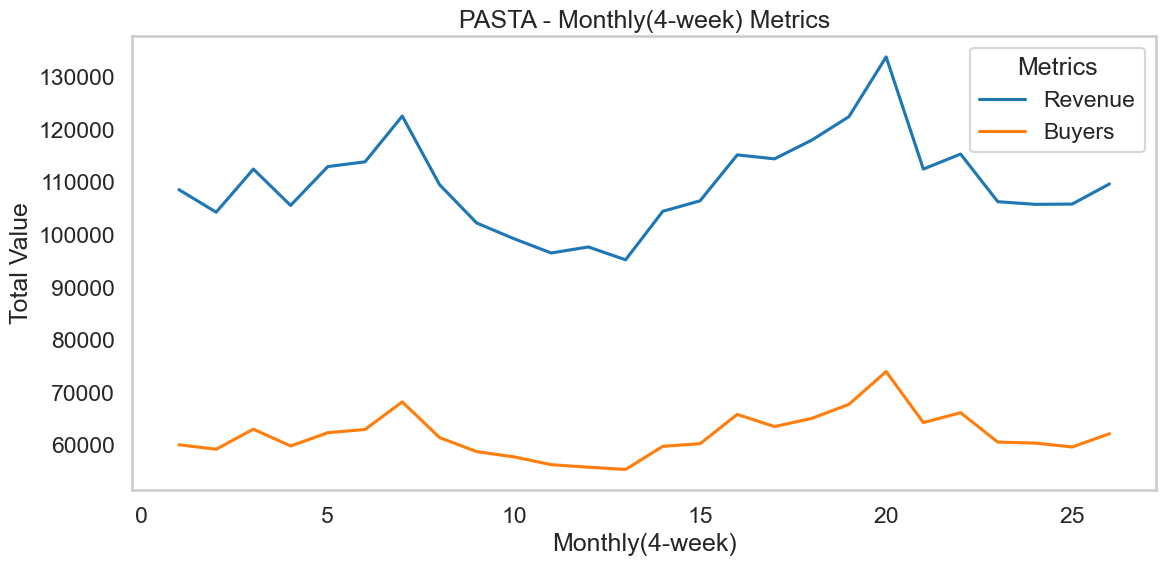

In [96]:
# Category monthly overview (PASTA total)
df_pasta['month'] = ((df_pasta['week'] - 1) // 4) + 1
months = sorted(df_pasta['month'].unique())

month_metrics = df_pasta.groupby("month", as_index=False).agg(
    month_revenue=("dollar_sales","sum"),
    month_units=("units","sum"),
    month_transactions=("basket","nunique"),
    month_buyers=("household","nunique")
)

plt.figure(figsize=(12,6))
sns.lineplot(data=month_metrics, x="month", y="month_revenue", label="Revenue")
sns.lineplot(data=month_metrics, x="month", y="month_buyers", label="Buyers")

plt.title("PASTA - Monthly(4-week) Metrics")
plt.xlabel("Monthly(4-week)")
plt.ylabel("Total Value")
plt.legend(title="Metrics")
plt.tight_layout()
plt.grid(False)
plt.savefig("/Users/ying/25001197/assignment_2 copy/outputs/figs/PASTA - Monthly(4-week) Metrics.png", dpi=300, bbox_inches="tight")   # high-res PNG
plt.show()

## 2.2 Category-level KPIs by brand

In [97]:
brand_quarter = df_pasta.groupby(["quarter","brand"], as_index=False).agg(
    revenue=("dollar_sales","sum"),
    units=("units","sum"),
    buyers=("household","nunique"),
    transactions=("basket","count")
)

# Merge category metrics per quarter
brand_quarter = brand_quarter.merge(
    quarter_metrics[["quarter","quarter_buyers","quarter_transactions","quarter_units","quarter_revenue"]].rename(
            columns={"quarter_buyers":"cat_buyers","quarter_transactions":"cat_transactions","quarter_units":"cat_units","quarter_revenue":"cat_revenue"}),
    on="quarter",how="left"
)
brand_quarter["penetration_b"] = brand_quarter["buyers"]  / brand_quarter["cat_buyers"]
brand_quarter["purchase_fre_w"] = brand_quarter["transactions"]  / brand_quarter["buyers"]
brand_quarter["market_share_vol"] = brand_quarter["units"] / brand_quarter.groupby("quarter")["units"].transform("sum")
brand_quarter["avg_spend_per_buyer"] = brand_quarter["revenue"] / brand_quarter["buyers"]

brand_quarter.to_csv("/Users/ying/25001197/assignment_2 copy/outputs/brand_quarter_kpis.csv")
brand_quarter.head()


,quarter,brand,revenue,units,buyers,transactions,cat_buyers,cat_transactions,cat_units,cat_revenue,penetration_b,purchase_fre_w,market_share_vol,avg_spend_per_buyer
0,1,Al Dente,609.61,159,119,155,137404,240167,353851,351531.55,0.000866,1.302521,0.000449,5.122773
1,1,Alessi,167.08,61,44,52,137404,240167,353851,351531.55,0.000320,1.181818,0.000172,3.797273
2,1,Annie Chns,5.78,2,2,2,137404,240167,353851,351531.55,0.000015,1.000000,0.000006,2.890000
3,1,Arlow,2.49,1,1,1,137404,240167,353851,351531.55,0.000007,1.000000,0.000003,2.490000
4,1,Barilla,42392.56,36426,20533,30287,137404,240167,353851,351531.55,0.149435,1.475040,0.102942,2.064606


## 2.3 Category-level repeat buying rates by quarters

   Quarter  Previous_Quarter  Previous_Buyers  Current_Buyers  Repeat_Buyers  Repeat_Rate(%)
0        2                 1           137404          141822          73864           53.76
1        3                 2           141822          138101          74153           52.29
2        4                 3           138101          128278          68437           49.56
3        5                 4           128278          141987          69036           53.82
4        6                 5           141987          149299          76851           54.13
5        7                 6           149299          147216          79172           53.03
6        8                 7           147216          139204          74718           50.75


/var/folders/_d/xcgr17q96l95x2dcnvhdt6sw0000gn/T/ipykernel_20464/2810175229.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Pasta")


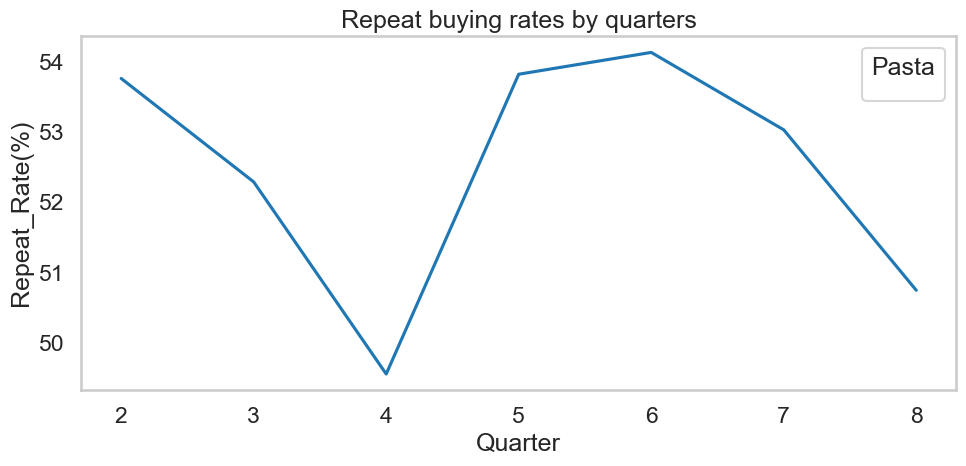

In [98]:
# Obtain raw statistics for quarter to quarter repeat buying

# Step 1. Initialize list to store results
results = []

repeat_buying_rates_q = {}

# Step 2. Loop through quarters, comparing current and previous ones
for i in range(1, len(quarters)):
    current_q = quarters[i]
    prev_q = quarters[i - 1]

    # Get unique households for current and previous quarters
    current_households = set(df_pasta[df_pasta['quarter'] == current_q]['household'])
    prev_households = set(df_pasta[df_pasta['quarter'] == prev_q]['household'])

    # Find repeat buyers
    repeat_customers = current_households.intersection(prev_households)

    # Calculate repeat buying rate
    repeat_rate = (len(repeat_customers) / len(prev_households) * 100) if len(prev_households) > 0 else 0

    results.append({
        "Quarter": current_q,
        "Previous_Quarter": prev_q,
        "Previous_Buyers": len(prev_households),
        "Current_Buyers": len(current_households),
        "Repeat_Buyers": len(repeat_customers),
        "Repeat_Rate(%)": round(repeat_rate, 2)
    })
    
# Step 3. Convert results into a DataFrame
repeat_buying_pasta = pd.DataFrame(results)

# Step 4. Display the result
print(repeat_buying_pasta)

# Step 5. Plot the trends
plt.figure(figsize=(10,5))
sns.lineplot(data=repeat_buying_pasta, x="Quarter",y="Repeat_Rate(%)")
plt.title("Repeat buying rates by quarters")
plt.xlabel("Quarter")
plt.ylabel("Repeat_Rate(%)")
plt.legend(title="Pasta")
plt.tight_layout()
plt.grid(False)
plt.show()
# The line is quarter-to-quarter retention: of last quarter’s pasta buyers, what % bought again this quarter.
# Pattern: Q2→Q4 declines, bottoms around ~49–50% at Q4, then rebounds to ~54% by Q6, and eases back to ~51% by Q8.
# Range is narrow: roughly 49.5%–54% (swing ≈ 4–5 pts). That’s stable category loyalty with some quarter noise.

## 2.4 Category-level: Distribution of buyer class

In [99]:
# Examine trends in the distribution of buyers by quarter

# Group transactions by household and quarter
customer_stats_total = df_pasta.groupby(['household', 'quarter']).agg({
    'basket': 'nunique'
}).reset_index()
customer_stats_total.columns = ['Household', 'quarter', 'Purchase_Frequency']

# Apply the purchase frequency classes
purchase_frequency_cutoff = 4
bins = list(range(0, purchase_frequency_cutoff+1)) + [float('inf')]
labels = [str(x) for x in range(purchase_frequency_cutoff)] + [f'{purchase_frequency_cutoff}+']
customer_stats_total['Purchase_Class'] = pd.cut(customer_stats_total['Purchase_Frequency'], bins=bins, right=False, labels=labels)

# Group by 'Quarter' and 'Purchase_Class' and count unique households
buyer_class_aggregated_total = customer_stats_total.groupby(['quarter', 'Purchase_Class']).agg({
    'Household': 'nunique'
}).reset_index()

# Rename the columns for clarity
buyer_class_aggregated_total.columns = ['quarter', 'Purchase_Class', 'Number_of_Buyers']

# Pivot the data to have purchase classes as rows and quarters as columns, fill missing with 0
purchase_class_per_quarter = buyer_class_aggregated_total.pivot(index='Purchase_Class', columns='quarter', values='Number_of_Buyers')
purchase_class_per_quarter = purchase_class_per_quarter.fillna(0).astype(int)

# Calculate zero buyers per quarter and add them to the pivoted DataFrame
total_buyers_per_quarter = purchase_class_per_quarter.sum()
zero_buyers_per_quarter = total_pasta_buyers - total_buyers_per_quarter
purchase_class_per_quarter.loc['0'] = zero_buyers_per_quarter

display(purchase_class_per_quarter)
buyer_class_aggregated_total.to_csv("/Users/ying/25001197/assignment_2 copy/outputs/buyer_class_aggregated_total.csv")
purchase_class_per_quarter.to_csv("/Users/ying/25001197/assignment_2 copy/outputs/purchase_class_per_quarter.csv")

/var/folders/_d/xcgr17q96l95x2dcnvhdt6sw0000gn/T/ipykernel_20464/3053281601.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  buyer_class_aggregated_total = customer_stats_total.groupby(['quarter', 'Purchase_Class']).agg({


quarter,1,2,3,4,5,6,7,8
Purchase_Class,,,,,,,,
0,274098,269680,273401,283224,269515,262203,264286,272298
1,83277,85351,83742,80180,86666,89686,88256,86025
2,29547,30717,29650,27028,30539,32198,32081,29270
3,12928,13300,12886,11163,13062,14066,13784,12515
4+,11652,12454,11823,9907,11720,13349,13095,11394


### Extend: Based on the "purchase_class_per_quarter" table, I've sorted the buyer-classes manually into four main types,e.g. zero-buyer, once-buyer, light-buyer(bought 2-3 times), and heavy-buyer(bought 4 & 4+ times).

/var/folders/_d/xcgr17q96l95x2dcnvhdt6sw0000gn/T/ipykernel_20464/1616295603.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  purchase_class_per_quarter.index = purchase_class_per_quarter.index.to_series().replace(mapping)
/var/folders/_d/xcgr17q96l95x2dcnvhdt6sw0000gn/T/ipykernel_20464/1616295603.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  purchase_class_per_quarter = purchase_class_per_quarter.groupby(purchase_class_per_quarter.index).sum()


quarter              1       2       3       4       5       6       7       8
Purchase_Class                                                                
zero_buyer      274098  269680  273401  283224  269515  262203  264286  272298
once_buyer       83277   85351   83742   80180   86666   89686   88256   86025
light_buyer      42475   44017   42536   38191   43601   46264   45865   41785
heavy_buyer      11652   12454   11823    9907   11720   13349   13095   11394


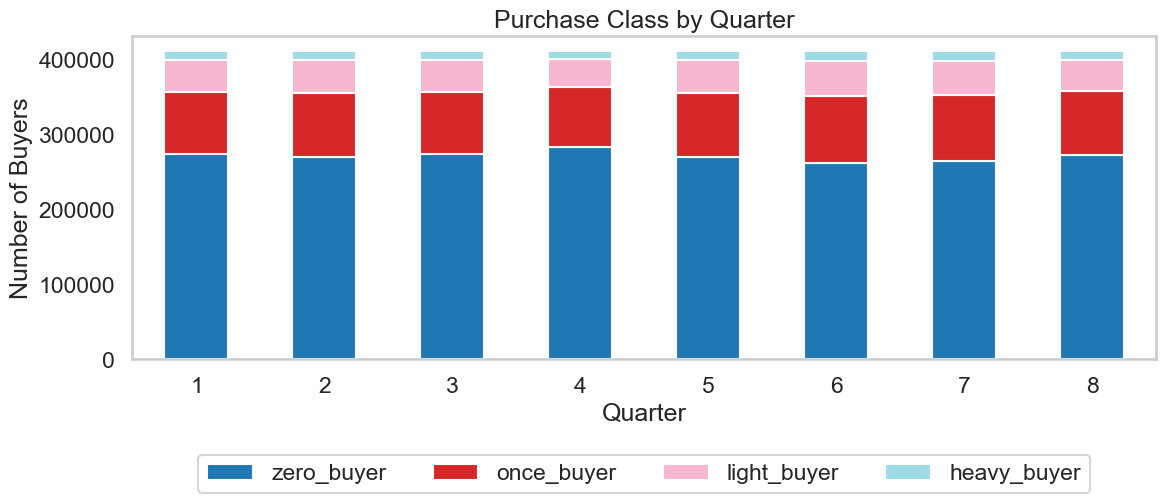

In [100]:
# define the class names
mapping = {
    "0": "zero_buyer",
    "1": "once_buyer",
    "2": "light_buyer",
    "3": "light_buyer",
    "4+": "heavy_buyer"
}

# replace the purchase class name
purchase_class_per_quarter.index = purchase_class_per_quarter.index.to_series().replace(mapping)

# aggregate the light_buyer class into one
purchase_class_per_quarter = purchase_class_per_quarter.groupby(purchase_class_per_quarter.index).sum()
print(purchase_class_per_quarter)

# plot the stacked bar plot to show the proportion of each purchase classs by quarter
ax = purchase_class_per_quarter.T.plot(
    kind="bar", 
    stacked=True, 
    figsize=(12,6),
    colormap="tab20"   # you can try "viridis", "Set2", etc.
)

plt.title("Purchase Class by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Number of Buyers")
plt.legend(bbox_to_anchor=(0.5, -0.45), loc="lower center",ncol=4)
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(False)
plt.savefig("/Users/ying/25001197/assignment_2 copy/outputs/figs/Manual Purchase Class by Quarter.png", dpi=300, bbox_inches="tight")
plt.show()


# 3) The focal brand "Barilla" dashboard

## 3.1 Calculate Barilla's KPIs

In [101]:
Barilla = df_pasta[df_pasta["brand"]=="Barilla"]
Barilla.to_csv("/Users/ying/25001197/assignment_2 copy/outputs/Barilla.csv")

Barilla_kpi_total = {
    "Total Revenue": float(Barilla["dollar_sales"].sum()),
    "Revenue share": float(Barilla["dollar_sales"].sum() / df_pasta["dollar_sales"].sum()),
    "Brand buyers": Barilla["household"].nunique(),
    "Brand penetration_b": Barilla["household"].nunique() / df_pasta["household"].nunique(),
    "Transactions": Barilla["basket"].nunique(),
    "Purchase frequency_w": Barilla["basket"].nunique() / Barilla["household"].nunique(),
    "Avg spend per buyer": float(Barilla["dollar_sales"].sum() / Barilla["household"].nunique())
}
Barilla_kpi_total

{'Total Revenue': 433893.83999999997,
 'Revenue share': 0.15210769197994164,
 'Brand buyers': 125508,
 'Brand penetration_b': 0.3049997326865969,
 'Transactions': 277192,
 'Purchase frequency_w': 2.2085604104917613,
 'Avg spend per buyer': 3.4571010612869295}

   quarter  Barilla_buyers  Barilla_transactions  Barilla_units  Barilla_revenue
0        1           20533                 25920          36426         42392.56
1        2           28391                 36752          53507         55272.11
2        3           28103                 36996          51428         54697.38
3        4           25344                 32868          48906         51998.82
4        5           26698                 35094          47282         55317.36


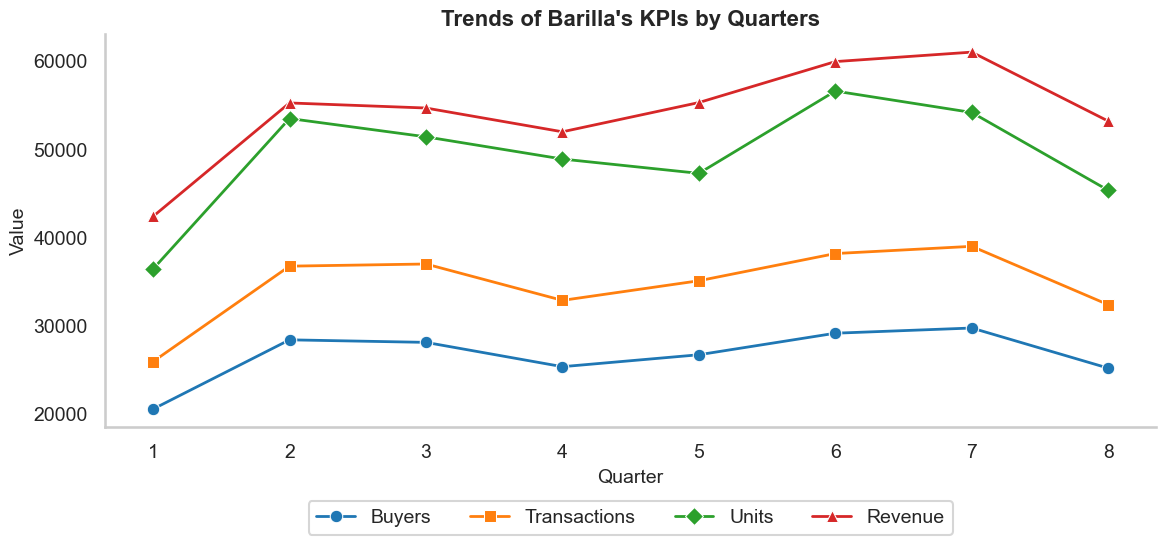

In [102]:
# Quarter-based Metrics of Barilla
quarter_Barilla = Barilla.groupby("quarter",as_index=False).agg(
    Barilla_buyers=("household","nunique"),
    Barilla_transactions=("basket","nunique"),
    Barilla_units=("units","sum"),
    Barilla_revenue=("dollar_sales","sum")
)
print(quarter_Barilla.head())

# Set graphs style
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize=(12, 6))

# Draw multiple KPI lines
sns.lineplot(data=quarter_Barilla, x="quarter", y="Barilla_buyers",
             label="Buyers", marker="o", linewidth=2)
sns.lineplot(data=quarter_Barilla, x="quarter", y="Barilla_transactions",
             label="Transactions", marker="s", linewidth=2)
sns.lineplot(data=quarter_Barilla, x="quarter", y="Barilla_units",
             label="Units", marker="D", linewidth=2)
sns.lineplot(data=quarter_Barilla, x="quarter", y="Barilla_revenue",
             label="Revenue", marker="^", linewidth=2)

plt.title("Trends of Barilla's KPIs by Quarters", fontsize=16, weight="bold")
plt.xlabel("Quarter", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(0.5, -0.3), loc="lower center",fontsize=14, ncol=8)
#plt.savefig("/Users/ying/25001197/assignment_2 copy/outputs/figs/Trends of Barilla's KPIs by Quarters.png", dpi=300, bbox_inches="tight")
sns.despine() # Remove top/right borders for cleaner look

plt.tight_layout()
plt.grid(False)

plt.savefig("/Users/ying/25001197/assignment_2 copy/outputs/figs/Trends of Barilla's KPIs by Quarters.png", dpi=300, bbox_inches="tight")
plt.show()
# Barilla’s quarterly performance shows early rapid growth, mid-term recovery, and recent volatility.
# Q1 → Q3: Strong expansion across all KPIs, driven by buyer acquisition and higher purchase volumes.
# Q4: First performance dip, possibly due to reduced promotional support or seasonal effects.
# Q5 → Q7: Recovery and stabilization, with Q7 marking peak revenue and unit sales.
# Q8: Broad-based decline across all KPIs, highlighting potential structural issues or competitive challenges.

## 3.2 Barilla's quarter-over-quarter (QoQ) increase rate

,quarter,Barilla_buyers,Barilla_transactions,Barilla_units,Barilla_revenue,buyers_increase_rate%,transactions_increase_rate%,units_increase_rate%,revenue_increase_rate%
0,1,20533,25920,36426,42392.56,NaN,NaN,NaN,NaN
1,2,28391,36752,53507,55272.11,38.27,41.79,46.89,30.38
2,3,28103,36996,51428,54697.38,-1.01,0.66,-3.89,-1.04
3,4,25344,32868,48906,51998.82,-9.82,-11.16,-4.90,-4.93
4,5,26698,35094,47282,55317.36,5.34,6.77,-3.32,6.38
5,6,29143,38182,56621,59965.20,9.16,8.80,19.75,8.40
6,7,29732,39001,54191,61039.52,2.02,2.14,-4.29,1.79
7,8,25179,32379,45359,53210.89,-15.31,-16.98,-16.30,-12.83


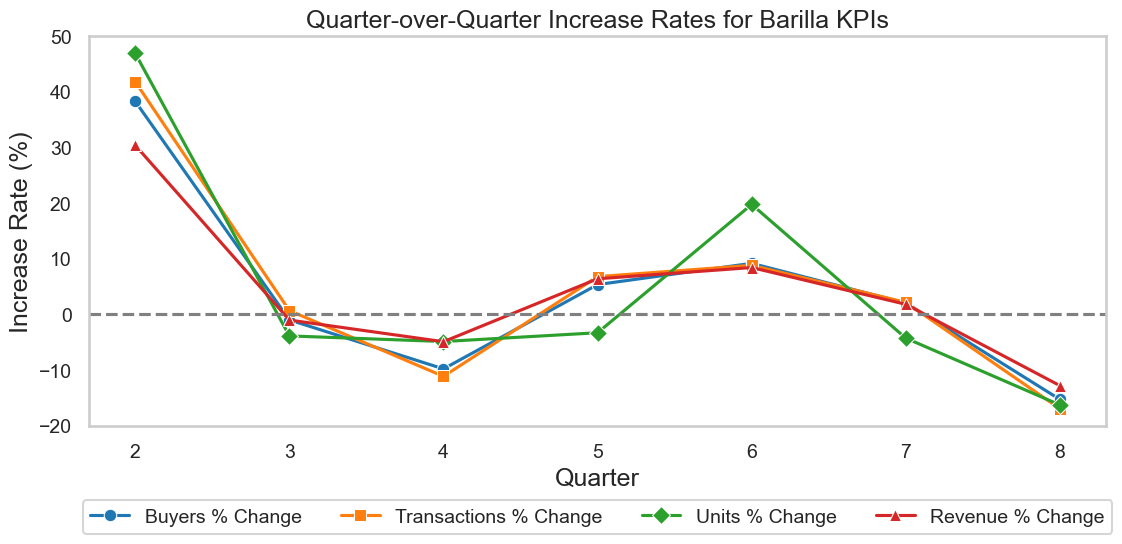

In [103]:
# Calculate QoQ increase rates
quarter_Barilla["buyers_increase_rate%"] = quarter_Barilla["Barilla_buyers"].pct_change()
quarter_Barilla["transactions_increase_rate%"] = quarter_Barilla["Barilla_transactions"].pct_change()
quarter_Barilla["units_increase_rate%"] = quarter_Barilla["Barilla_units"].pct_change()
quarter_Barilla["revenue_increase_rate%"] = quarter_Barilla["Barilla_revenue"].pct_change()

# Convert rates to percentage format and round to 2 decimal places
quarter_Barilla["buyers_increase_rate%"] = (quarter_Barilla["buyers_increase_rate%"] * 100).round(2)
quarter_Barilla["transactions_increase_rate%"] = (quarter_Barilla["transactions_increase_rate%"] * 100).round(2)
quarter_Barilla["units_increase_rate%"] = (quarter_Barilla["units_increase_rate%"] * 100).round(2)
quarter_Barilla["revenue_increase_rate%"] = (quarter_Barilla["revenue_increase_rate%"] * 100).round(2)

# Save csv files
quarter_Barilla.to_csv("/Users/ying/25001197/assignment_2 copy/outputs/quarter_Barilla.csv")
display(quarter_Barilla)

# Visulization
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.lineplot(data=quarter_Barilla, x="quarter", y="buyers_increase_rate%", label="Buyers % Change", marker="o")
sns.lineplot(data=quarter_Barilla, x="quarter", y="transactions_increase_rate%", label="Transactions % Change", marker="s")
sns.lineplot(data=quarter_Barilla, x="quarter", y="units_increase_rate%", label="Units % Change", marker="D")
sns.lineplot(data=quarter_Barilla, x="quarter", y="revenue_increase_rate%", label="Revenue % Change", marker="^")

plt.axhline(0, color="gray", linestyle="--")
plt.title("Quarter-over-Quarter Increase Rates for Barilla KPIs")
plt.xlabel("Quarter")
plt.ylabel("Increase Rate (%)")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(bbox_to_anchor=(0.5, -0.3), loc="lower center",fontsize=14, ncol=8)

plt.tight_layout()
plt.grid(False)
plt.savefig("/Users/ying/25001197/assignment_2 copy/outputs/figs/Quarter-over-Quarter Increase Rates for Barilla KPIs.png", dpi=300, bbox_inches="tight")
plt.show()

## 3.3 Barilla repeat buying rates by quarters

In [104]:
# Sort the quarters to check if they were consecutive.
quarters_1=sorted(Barilla["quarter"].unique())

# Initialize list to store results
results_Barilla = []
repeat_buying_rate_q_Barilla = {}

# Loop through quarters, comparing current and previous ones
for i in range(1,len(quarters_1)):
    current_q = quarters_1[i]
    prev_q = quarters_1[i - 1]

    # Get unique households for current and previous quarters
    current_household_Barilla = set(Barilla[Barilla["quarter"] == current_q]["household"])
    prev_household_Barilla = set(Barilla[Barilla["quarter"] == prev_q]["household"])
    
    # Find repeat buyers of the focal brand "Barilla"
    repeat_buyers_Barilla = current_household_Barilla.intersection(prev_household_Barilla)
    
    # Calculate repeat buying rate
    repeat_buying_rate = (len(repeat_buyers_Barilla)/len(prev_household_Barilla) * 100) if len(prev_household_Barilla) > 0 else 0
    
    results_Barilla.append({
            "Quarter": current_q,
            "Previous_Quarter": prev_q,
            "Previous_Buyers": len(prev_household_Barilla),
            "Current_Buyers_Barilla": len(current_household_Barilla),
            "Repeat_Buyers_Barilla": len(repeat_buyers_Barilla),
            "Repeat_Rate_Barilla(%)": round(repeat_buying_rate, 2)
        })
    # Convert results into a DataFrame
    repeat_buying_Barilla = pd.DataFrame(results_Barilla)

repeat_buying_Barilla

,Quarter,Previous_Quarter,Previous_Buyers,Current_Buyers_Barilla,Repeat_Buyers_Barilla,Repeat_Rate_Barilla(%)
0,2,1,20533,28391,6408,31.21
1,3,2,28391,28103,8071,28.43
2,4,3,28103,25344,7310,26.01
3,5,4,25344,26698,7109,28.05
4,6,5,26698,29143,7875,29.50
5,7,6,29143,29732,8366,28.71
6,8,7,29732,25179,7506,25.25


## 3.4 Distribution of Buyer Classes in total - Barilla

In [124]:
# Examine trends in the distribution of buyers by quarter

# Group transactions by household and quarter
customer_stats_Barilla_total = Barilla.groupby(['household', 'quarter']).agg({
    'basket': 'nunique'
}).reset_index()
customer_stats_Barilla_total.columns = ['Household', 'quarter', 'Purchase_Frequency']

# Apply the purchase frequency classes
purchase_frequency_cutoff = 4
bins = list(range(0, purchase_frequency_cutoff+1)) + [float('inf')]
labels = [str(x) for x in range(purchase_frequency_cutoff)] + [f'{purchase_frequency_cutoff}+']
customer_stats_Barilla_total['Purchase_Class'] = pd.cut(customer_stats_Barilla_total['Purchase_Frequency'], bins=bins, right=False, labels=labels)

# Group by 'Quarter' and 'Purchase_Class' and count unique households
buyer_class_aggregated_Barilla = customer_stats_Barilla_total.groupby(['quarter', 'Purchase_Class']).agg({
    'Household': 'nunique'
}).reset_index()

# Rename the columns for clarity
buyer_class_aggregated_Barilla.columns = ['quarter', 'Purchase_Class', 'Number_of_Buyers']

# Pivot the data to have purchase classes as rows and quarters as columns, fill missing with 0
Barilla_purchase_class_per_quarter = buyer_class_aggregated_Barilla.pivot(index='Purchase_Class', columns='quarter', values='Number_of_Buyers')
Barilla_purchase_class_per_quarter = Barilla_purchase_class_per_quarter.fillna(0).astype(int)

# Calculate zero buyers per quarter and add them to the pivoted DataFrame
Barilla_total_buyers_per_quarter = Barilla_purchase_class_per_quarter.sum()
Barilla_zero_buyers_per_quarter = total_pasta_buyers - Barilla_total_buyers_per_quarter
Barilla_purchase_class_per_quarter.loc['0'] = Barilla_zero_buyers_per_quarter

display(Barilla_purchase_class_per_quarter)
buyer_class_aggregated_Barilla.to_csv("/Users/ying/25001197/assignment_2 copy/outputs/buyer_class_aggregated_Barilla.csv")
Barilla_purchase_class_per_quarter.to_csv("/Users/ying/25001197/assignment_2 copy/outputs/Barilla_purchase_class_per_quarter.csv")

/var/folders/_d/xcgr17q96l95x2dcnvhdt6sw0000gn/T/ipykernel_20464/1768899027.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  buyer_class_aggregated_Barilla = customer_stats_Barilla_total.groupby(['quarter', 'Purchase_Class']).agg({


quarter,1,2,3,4,5,6,7,8
Purchase_Class,,,,,,,,
0,390969,383111,383399,386158,384804,382359,381770,386323
1,16956,22920,22388,20449,21273,23328,23765,20479
2,2490,3777,3921,3356,3694,3988,4093,3272
3,666,1043,1063,928,1058,1078,1120,862
4+,421,651,731,611,673,749,754,566


/var/folders/_d/xcgr17q96l95x2dcnvhdt6sw0000gn/T/ipykernel_20464/2048680823.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Barilla_purchase_class_per_quarter = Barilla_purchase_class_per_quarter.groupby(Barilla_purchase_class_per_quarter.index).sum()


quarter              1       2       3       4       5       6       7       8
Purchase_Class                                                                
zero_buyer      390969  383111  383399  386158  384804  382359  381770  386323
once_buyer       16956   22920   22388   20449   21273   23328   23765   20479
light_buyer       3156    4820    4984    4284    4752    5066    5213    4134
heavy_buyer        421     651     731     611     673     749     754     566


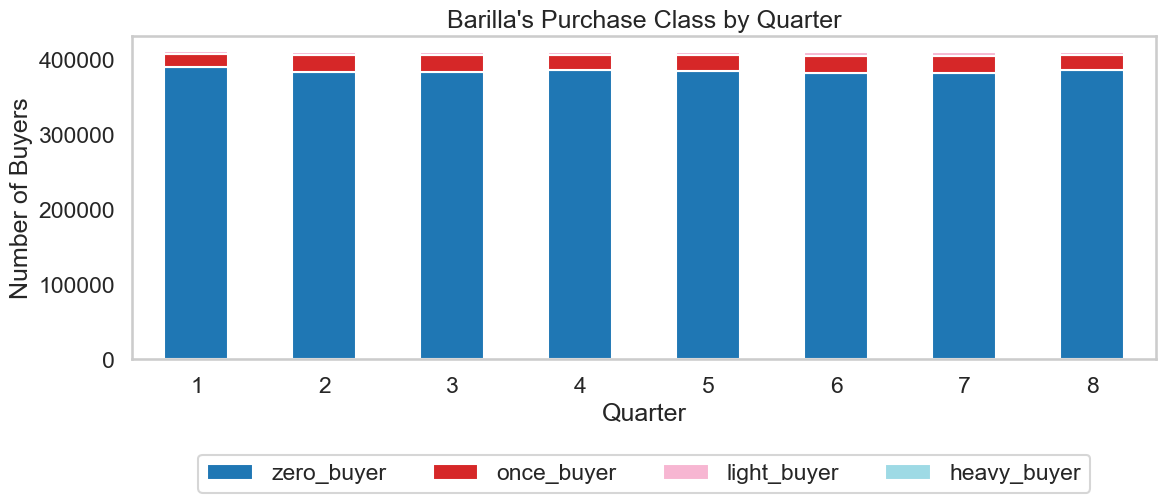

In [126]:
# define the class names
mapping = {
    "0": "zero_buyer",
    "1": "once_buyer",
    "2": "light_buyer",
    "3": "light_buyer",
    "4+": "heavy_buyer"
}

# replace the purchase class name
Barilla_purchase_class_per_quarter.index = Barilla_purchase_class_per_quarter.index.to_series().replace(mapping)

# aggregate the light_buyer class into one
Barilla_purchase_class_per_quarter = Barilla_purchase_class_per_quarter.groupby(Barilla_purchase_class_per_quarter.index).sum()
Barilla_purchase_class_per_quarter.to_csv("/Users/ying/25001197/assignment_2 copy/outputs/Manually sorted buyer class of Barilla.csv")
print(Barilla_purchase_class_per_quarter)

# plot the stacked bar plot to show the proportion of each purchase classs by quarter
ax = Barilla_purchase_class_per_quarter.T.plot(
    kind="bar", 
    stacked=True, 
    figsize=(12,6),
    colormap="tab20"   # you can try "viridis", "Set2", etc.
)

plt.title("Barilla's Purchase Class by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Number of Buyers")
plt.legend(bbox_to_anchor=(0.5, -0.45), loc="lower center",ncol=4)
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(False)
plt.savefig("/Users/ying/25001197/assignment_2 copy/outputs/figs/Barilla_purchase_class_per_quarter.png", dpi=300, bbox_inches="tight")
plt.show()


## 3.5 Barilla's Customer Base per quarter

In [127]:
# Aggregate transactions into one per customer
Barilla_buyer_class_contribution = Barilla.groupby('household').agg({
    'basket': 'nunique',
    'dollar_sales': 'sum',
    'units': 'sum',
}).reset_index()
Barilla_buyer_class_contribution.columns = ['Household', 'Purchase_Frequency', 'Total_Revenue', 'Total_Items']

# Aggregate customers in purchase frequency classses with a user specified cutoff
purchase_frequency_cutoff = 4

bins = list(range(0, purchase_frequency_cutoff+1)) + [float('inf')]
labels = [str(x) for x in range(purchase_frequency_cutoff)] + [f'{purchase_frequency_cutoff}+']
Barilla_buyer_class_contribution['Purchase_Class'] = pd.cut(Barilla_buyer_class_contribution['Purchase_Frequency'], bins=bins, right=False, 
    labels=labels)
Barilla_buyer_class_aggregated_total = Barilla_buyer_class_contribution.groupby('Purchase_Class').agg({
    'Household': 'nunique',
    'Total_Revenue': 'sum',
    'Total_Items': 'sum'
}).rename(columns={'Household': 'Number_of_Buyers'})

# Adjust for zero buyers
Barilla_zero_buyers_total = total_pasta_buyers - Barilla["household"].nunique()
print("Barilla_zero_buyers_total = ", Barilla_zero_buyers_total)

Barilla_buyer_class_aggregated_total.loc['0', 'Number_of_Buyers'] += Barilla_zero_buyers_total
Barilla_buyer_class_aggregated_total['Percent_Total_Buyers'] = (
    Barilla_buyer_class_aggregated_total['Number_of_Buyers'] / Barilla_buyer_class_aggregated_total['Number_of_Buyers'].sum() * 100
)
Barilla_buyer_class_aggregated_total['Percent_Total_Revenue'] = (
    Barilla_buyer_class_aggregated_total['Total_Revenue'] / Barilla_buyer_class_aggregated_total['Total_Revenue'].sum() * 100
)           
Barilla_buyer_class_aggregated_total.loc['0', 'Percent_Total_Buyers'] = (Barilla_zero_buyers_total / total_pasta_buyers) *100

Barilla_buyer_class_aggregated_total = Barilla_buyer_class_aggregated_total.apply(pd.to_numeric, errors='coerce').round(0)

display(Barilla_buyer_class_aggregated_total)

# define the class names
mapping = {
    "0": "zero_buyer",
    "1": "once_buyer",
    "2": "light_buyer",
    "3": "light_buyer",
    "4+": "heavy_buyer"
}

# replace the purchase class name
Barilla_buyer_class_aggregated_total.index = Barilla_buyer_class_aggregated_total.index.to_series().replace(mapping)
Barilla_buyer_class_aggregated_total = Barilla_buyer_class_aggregated_total.groupby(Barilla_buyer_class_aggregated_total.index).sum()

Barilla_buyer_class_aggregated_total.to_csv("/Users/ying/25001197/assignment_2 copy/outputs/Barilla_buyer_class_aggregated_total.csv")
Barilla_buyer_class_aggregated_total

Barilla_zero_buyers_total =  285994


/var/folders/_d/xcgr17q96l95x2dcnvhdt6sw0000gn/T/ipykernel_20464/3218592231.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Barilla_buyer_class_aggregated_total = Barilla_buyer_class_contribution.groupby('Purchase_Class').agg({


,Number_of_Buyers,Total_Revenue,Total_Items,Percent_Total_Buyers,Percent_Total_Revenue
Purchase_Class,,,,,
0,285994,0.0,0,70.0,0.0
1,75182,110276.0,102516,18.0,25.0
2,22624,68032.0,62261,5.0,16.0
3,10184,47340.0,42682,2.0,11.0
4+,17518,208246.0,186261,4.0,48.0


/var/folders/_d/xcgr17q96l95x2dcnvhdt6sw0000gn/T/ipykernel_20464/3218592231.py:49: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  Barilla_buyer_class_aggregated_total.index = Barilla_buyer_class_aggregated_total.index.to_series().replace(mapping)
/var/folders/_d/xcgr17q96l95x2dcnvhdt6sw0000gn/T/ipykernel_20464/3218592231.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Barilla_buyer_class_aggregated_total = Barilla_buyer_class_aggregated_total.groupby(Barilla_buyer_class_aggregated_total.index).sum()


,Number_of_Buyers,Total_Revenue,Total_Items,Percent_Total_Buyers,Percent_Total_Revenue
Purchase_Class,,,,,
zero_buyer,285994,0.0,0,70.0,0.0
once_buyer,75182,110276.0,102516,18.0,25.0
light_buyer,32808,115372.0,104943,7.0,27.0
heavy_buyer,17518,208246.0,186261,4.0,48.0


## 3.6 Comparison: Barilla-repeat-buying-rate vs Category-repeat-buying-rate

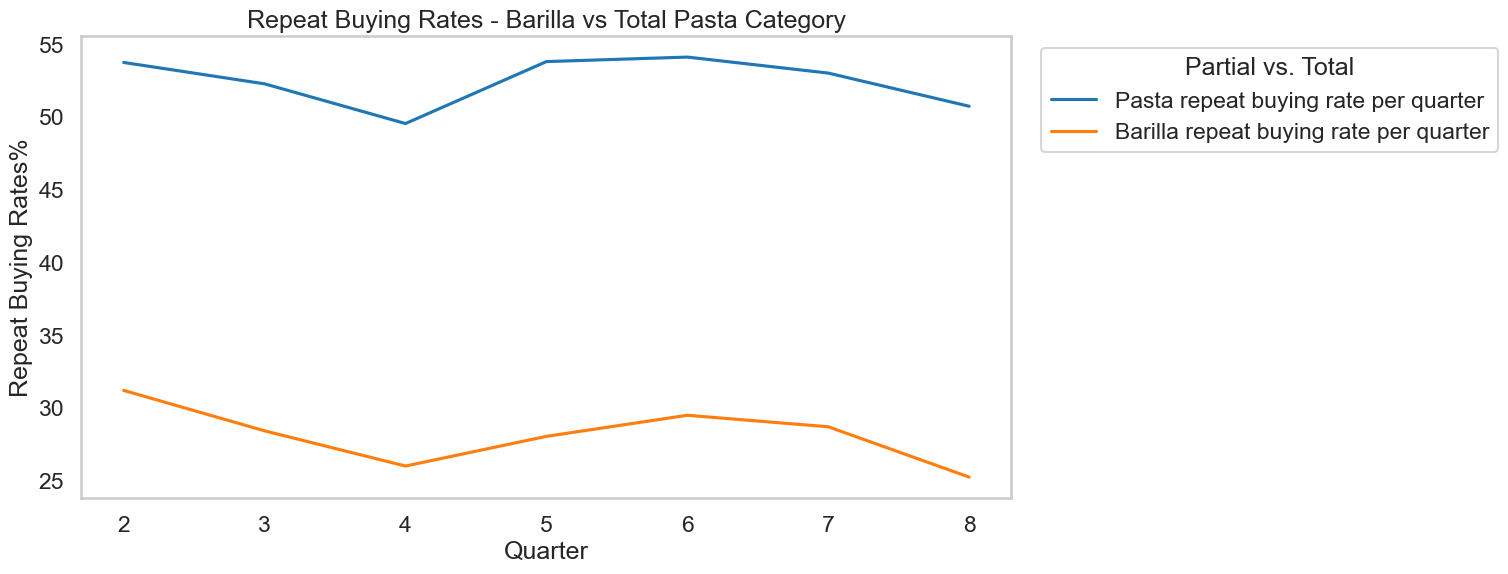

In [128]:
plt.figure(figsize=(12,6))

sns.lineplot(data=repeat_buying_pasta,x="Quarter",y="Repeat_Rate(%)",label="Pasta repeat buying rate per quarter")
sns.lineplot(data=repeat_buying_Barilla,x="Quarter",y="Repeat_Rate_Barilla(%)",label="Barilla repeat buying rate per quarter")

plt.title("Repeat Buying Rates - Barilla vs Total Pasta Category")
plt.xlabel("Quarter")
plt.ylabel("Repeat Buying Rates%")
plt.legend(title="Partial vs. Total", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(False)
plt.show()

# Key takeaways
# Barilla’s repeat is much lower than the category’s (gap ~20–27 pts). That’s expected in repertoire markets: brands suffer double jeopardy—smaller brands have fewer buyers and those buyers also repurchase a bit less often than big brands (Dirichlet/Ehrenberg norm).
# Category retention is high and fairly stable. The category keeps about half its buyers each quarter—healthy, showing stable demand with mild quarter-to-quarter noise.
# Barilla shows a gentle dip then small recovery, then a drop at Q8. Falls from ~30% (Q2) to ~26% (Q4), rises ~28–29% (Q5–Q7), then drops to ~25% (Q8).


# 4) Analysis of the last quarter & Examine brand performance & Model Fitting

## 4.1 find out the last quarter with full week (just pasta data included)

In [109]:
last_q = df_pasta["quarter"].max()
df_pasta_last_q = df_pasta[df_pasta["quarter"]==last_q]
df_pasta_last_q.to_csv("/Users/ying/25001197/assignment_2 copy/outputs/pasta_last_q.csv")
df_pasta_last_q.head()

,upc,week,day,brand,household,basket,units,dollar_sales,unit_price,quarter,month
2037370,9999985021,92,638,Private Label,448290,2906771,1,0.79,0.784337,8,23
2037371,9999985071,92,638,Private Label,381813,2906772,1,0.67,0.784337,8,23
2037372,9999985126,92,638,Private Label,288002,2906773,1,1.00,0.784337,8,23
2037373,9999985046,92,638,Private Label Premium,383176,2906774,1,0.88,1.001278,8,23
2037374,9999985072,92,638,Private Label,449565,2906776,1,0.67,0.784337,8,23


## 4.2 KPIs in the last quarter

In [110]:
# Total category buyers in last quarter √
pasta_category_buyers_last_q = df_pasta_last_q['household'].nunique()
category_zero_buyers_last_q = total_pasta_buyers - pasta_category_buyers_last_q
all_customers = total_carboload["household"].nunique()
pasta_penetration_B = pasta_category_buyers_last_q / all_customers

print('total number of category buyers =', total_pasta_buyers)
print("last quarter's category buyers =",pasta_category_buyers_last_q)
print("all customers = ",all_customers)
print("B =",pasta_penetration_B)

# Calculate brand KPIs in last q and save into a csv file
brand_metrics_last_q = df_pasta_last_q.groupby("brand",as_index=False).agg(
    buyers=("household","nunique"),
    transactions=("basket","nunique"),
    units=("units","sum"),
    revenue=("dollar_sales","sum")
)

brand_metrics_last_q["penetration_b"] = brand_metrics_last_q["buyers"] / total_pasta_buyers
brand_metrics_last_q["purchase_fre_w"] = brand_metrics_last_q["transactions"] / brand_metrics_last_q["buyers"]
brand_metrics_last_q["market_share_vol"] = brand_metrics_last_q["units"] / brand_metrics_last_q["units"].sum()

category_purchase_fre_last_q_W = df_pasta_last_q["basket"].nunique() / df_pasta_last_q["household"].nunique()
print("purchase frequency W in last quarter =",category_purchase_fre_last_q_W)

print(brand_metrics_last_q.head())

# -------------------------------------------------------------------------------------

# SCR

# Share of category requirements in last quarter (SCR (units & spend) = brand purchases/total category purchases by brand buyers)

# total category units per household (within last quarter)
hh_tot = df_pasta_last_q.groupby('household', as_index=False)['units'].sum().rename(columns={'units':'hh_units_total'})

# households who bought each brand at least once (buyers)
buyers = df_pasta_last_q[['brand','household']].drop_duplicates().merge(hh_tot, on='household', how='left')

# denominator: total category units by each brand's buyers (any brand)
denom = buyers.groupby('brand', as_index=True)['hh_units_total'].sum().rename('denom_units')

# numerator: total units on the focal brand by its buyers (equals brand units in this filtered df)
numer = df_pasta_last_q.groupby('brand', as_index=True)['units'].sum().rename('numer_units')

# SCR = brand units / total category units by that brand's buyers
scr = (pd.concat([numer, denom], axis=1)
         .assign(SCR=lambda x: x['numer_units'] / x['denom_units'],
                 SCR_pct=lambda x: (100 * x['SCR']).round(2))
         .sort_values('SCR', ascending=False))

print(scr.reset_index().head())

# -------------------------------------------------------------------------------------

# Sole loyalty%

# Sole loyalty % = household who bought only brand B / households who bought brand B

# How many distinct brands each household bought in the period
hh_brand_counts = (df_pasta_last_q.groupby('household')['brand']
                     .nunique()
                     .rename('n_brands')
                     .reset_index())

# For each brand, list its buyers
brand_buyers = df_pasta_last_q[['brand','household']].drop_duplicates()

# Merge to know, for each (brand, household), how many brands that household bought
bb = brand_buyers.merge(hh_brand_counts, on='household', how='left')

# Sole buyers for a brand = buyers whose n_brands == 1
sole_by_brand = (bb.assign(is_sole=lambda x: (x['n_brands'] == 1))
                   .groupby('brand', as_index=True)
                   .agg(total_buyers=('household','nunique'),
                        sole_buyers =('is_sole','sum'))
                )

sole_loyalty = (sole_by_brand
                .assign(sole_loyalty = lambda x: x['sole_buyers'] / x['total_buyers'],
                        sole_loyalty_pct = lambda x: (100*x['sole_loyalty']).round(2))
               ).sort_values('sole_loyalty', ascending=False)

print(sole_loyalty.reset_index().head())

total number of category buyers = 411502
last quarter's category buyers = 139204
all customers =  510027
B = 0.2729345701306009
purchase frequency W in last quarter = 1.723779489095141
          brand  buyers  transactions  units   revenue  penetration_b  purchase_fre_w  market_share_vol
0      Al Dente     208           242    263    984.97       0.000505        1.163462          0.000724
1        Alessi      30            33     33    109.17       0.000073        1.100000          0.000091
2       Barilla   25179         32379  45359  53210.89       0.061188        1.285953          0.124947
3  Barilla Plus    4769          5825   7598  12639.29       0.011589        1.221430          0.020930
4       Bellino       1             1      1      3.19       0.000002        1.000000          0.000003
            brand  numer_units  denom_units       SCR  SCR_pct
0         Bellino            1            1  1.000000   100.00
1          Edd Og            7            7  1.000000   100.00
2 

## 4.3 Merge brand KPIs, SCR, and Sole loyalty by brand - brand_metrics_last_q_final

In [111]:
merge_1 = brand_metrics_last_q.merge(scr,on="brand",how="left")
merge_2 = merge_1.merge(sole_loyalty,on="brand",how="left")
brand_metrics_last_q_final = merge_2.sort_values("market_share_vol",ascending=False)
brand_metrics_last_q_final.to_csv("/Users/ying/25001197/assignment_2 copy/outputs/brand_metrics_last_q_final.csv")
brand_metrics_last_q_final.head()

,brand,buyers,transactions,units,revenue,penetration_b,purchase_fre_w,market_share_vol,numer_units,denom_units,SCR,SCR_pct,total_buyers,sole_buyers,sole_loyalty,sole_loyalty_pct
30,Private Label,75053,112835,174062,117459.12,0.182388,1.503404,0.479477,174062,230793,0.754191,75.42,75053,49830,0.663931,66.39
2,Barilla,25179,32379,45359,53210.89,0.061188,1.285953,0.124947,45359,89439,0.507150,50.72,25179,11104,0.441002,44.10
35,Ronzoni,16967,21224,27933,33934.60,0.041232,1.250899,0.076945,27933,57953,0.481994,48.20,16967,7276,0.428832,42.88
7,Creamette,16612,21341,26793,29796.56,0.040369,1.284674,0.073805,26793,51307,0.522209,52.22,16612,8343,0.502227,50.22
31,Private Label Premium,14880,18654,26324,26427.68,0.036160,1.253629,0.072513,26324,55146,0.477351,47.74,14880,6266,0.421102,42.11


## 4.4 Plots

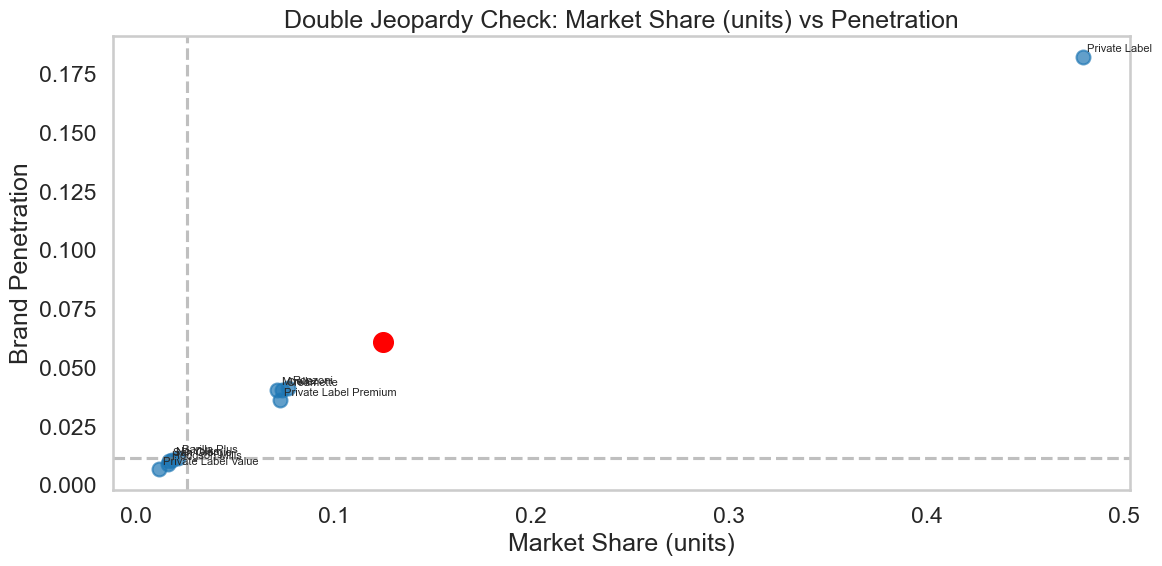

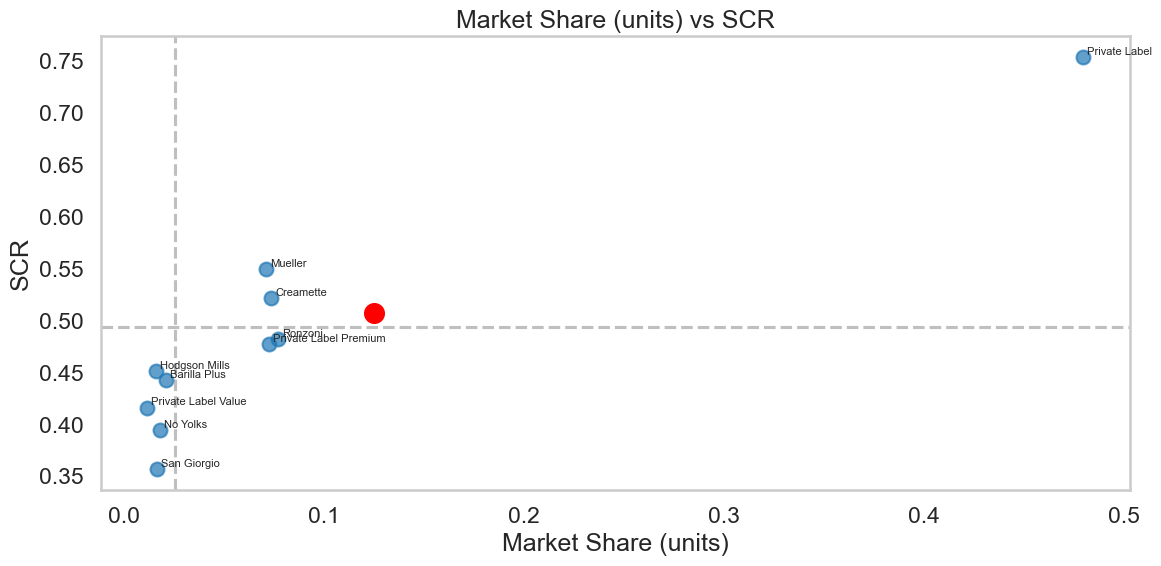

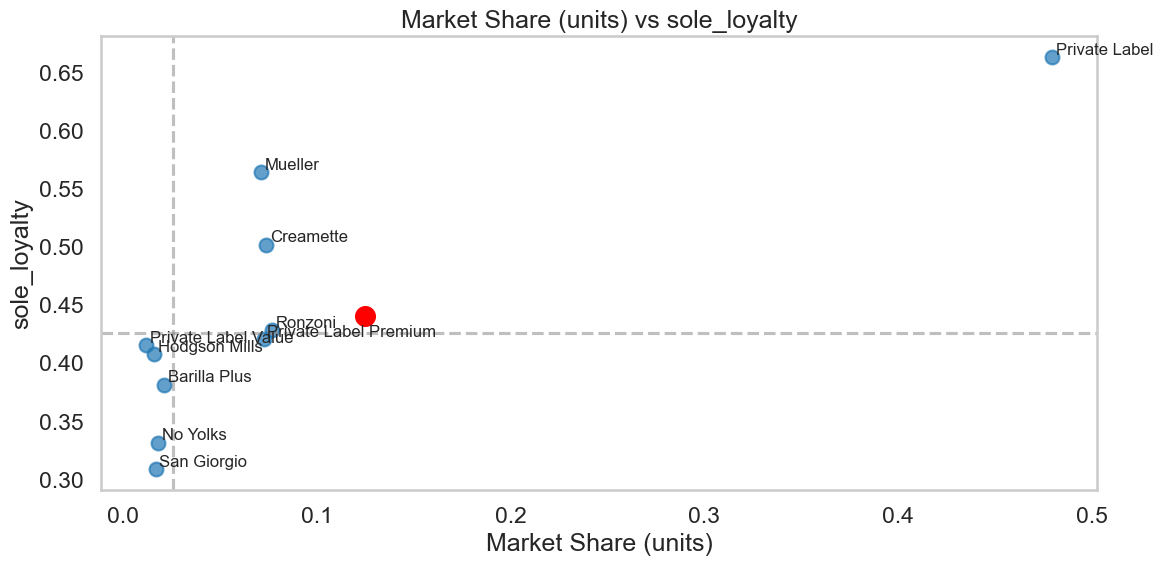

In [112]:
plt.figure(figsize=(12,6))

# filter (≥ 5% MS)
head_pasta_brands_last_q = (brand_metrics_last_q_final[brand_metrics_last_q_final["market_share_vol"]>=.01]).sort_values("market_share_vol",ascending=False)

# Scatterpoint graph: Market share & Penetration
plt.scatter(
    head_pasta_brands_last_q["market_share_vol"],
    head_pasta_brands_last_q["penetration_b"],
    s=100,
    alpha=0.7
)

# highlight Barilla + label others
for _, row in head_pasta_brands_last_q.iterrows():
    if row["brand"] == "Barilla":
        plt.scatter(row["market_share_vol"], row["penetration_b"],
                    s=200, edgecolor="red", facecolor="red", linewidths=1.0,
                    label="Barilla", zorder=3)
    else:
        # small offset instead of scaling (more stable for tiny values)
        plt.text(row["market_share_vol"] + 0.002,
                 row["penetration_b"] + 0.002,
                 row["brand"], fontsize=8)

plt.xlabel("Market Share (units)")
plt.ylabel("Brand Penetration")
plt.title("Double Jeopardy Check: Market Share (units) vs Penetration")
plt.axhline(y=brand_metrics_last_q_final["penetration_b"].mean(), color="grey", linestyle="--", alpha=0.5)
plt.axvline(x=brand_metrics_last_q_final["market_share_vol"].mean(), color="grey", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.grid(False)
plt.savefig("/Users/ying/25001197/assignment_2 copy/outputs/figs/Market Share (units) vs Penetration.png", dpi=300, bbox_inches="tight")
plt.show()

#  Scatterpoint graph: Market share & SCR
plt.figure(figsize=(12,6))
plt.scatter(
    head_pasta_brands_last_q["market_share_vol"],
    head_pasta_brands_last_q["SCR"],
    s=100,
    alpha=0.7
)

# highlight Barilla + label others
for _, row in head_pasta_brands_last_q.iterrows():
    if row["brand"] == "Barilla":
        plt.scatter(row["market_share_vol"], row["SCR"],
                    s=200, edgecolor="red", facecolor="red", linewidths=1.0,
                    label="Barilla", zorder=3)
    else:
        # small offset instead of scaling (more stable for tiny values)
        plt.text(row["market_share_vol"] + 0.002,
                 row["SCR"] + 0.002,
                 row["brand"], fontsize=8)

plt.xlabel("Market Share (units)")
plt.ylabel("SCR")
plt.title("Market Share (units) vs SCR")
plt.axhline(y=brand_metrics_last_q_final["SCR"].mean(), color="grey", linestyle="--", alpha=0.5)
plt.axvline(x=brand_metrics_last_q_final["market_share_vol"].mean(), color="grey", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.grid(False)

plt.savefig("/Users/ying/25001197/assignment_2 copy/outputs/figs/Market Share (units) vs SCR.png", dpi=300, bbox_inches="tight")
plt.show()

#  Scatterpoint graph: Market share & Sole loyalty
plt.figure(figsize=(12,6))
plt.scatter(
    head_pasta_brands_last_q["market_share_vol"],
    head_pasta_brands_last_q["sole_loyalty"],
    s=100,
    alpha=0.7
)

# highlight Barilla + label others
for _, row in head_pasta_brands_last_q.iterrows():
    if row["brand"] == "Barilla":
        plt.scatter(row["market_share_vol"], row["sole_loyalty"],
                    s=200, edgecolor="red", facecolor="red", linewidths=1.0,
                    label="Barilla", zorder=3)
    else:
        # small offset instead of scaling (more stable for tiny values)
        plt.text(row["market_share_vol"] + 0.002,
                 row["sole_loyalty"] + 0.002,
                 row["brand"], fontsize=12)

plt.xlabel("Market Share (units)")
plt.ylabel("sole_loyalty")
plt.title("Market Share (units) vs sole_loyalty")
plt.axhline(y=brand_metrics_last_q_final["sole_loyalty"].mean(), color="grey", linestyle="--", alpha=0.5)
plt.axvline(x=brand_metrics_last_q_final["market_share_vol"].mean(), color="grey", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.grid(False)
plt.savefig("/Users/ying/25001197/assignment_2 copy/outputs/figs/Market Share (units) vs sole_loyalty.png", dpi=300, bbox_inches="tight")
plt.show()

## 4.5 Duplication Matrix in the last quarter - competitors

Barilla overlaps most with (top 10):
Barilla                  1.000
Private Label            0.295
Ronzoni                  0.130
Private Label Premium    0.112
Creamette                0.079
Mueller                  0.077
Barilla Plus             0.041
No Yolks                 0.028
San Giorgio              0.026
Hodgson Mills            0.019
Name: Dup(Barilla → j), dtype: float64

Duplication vs volume-share MAE (lower ≈ closer to Dirichlet expectation): 0.0465


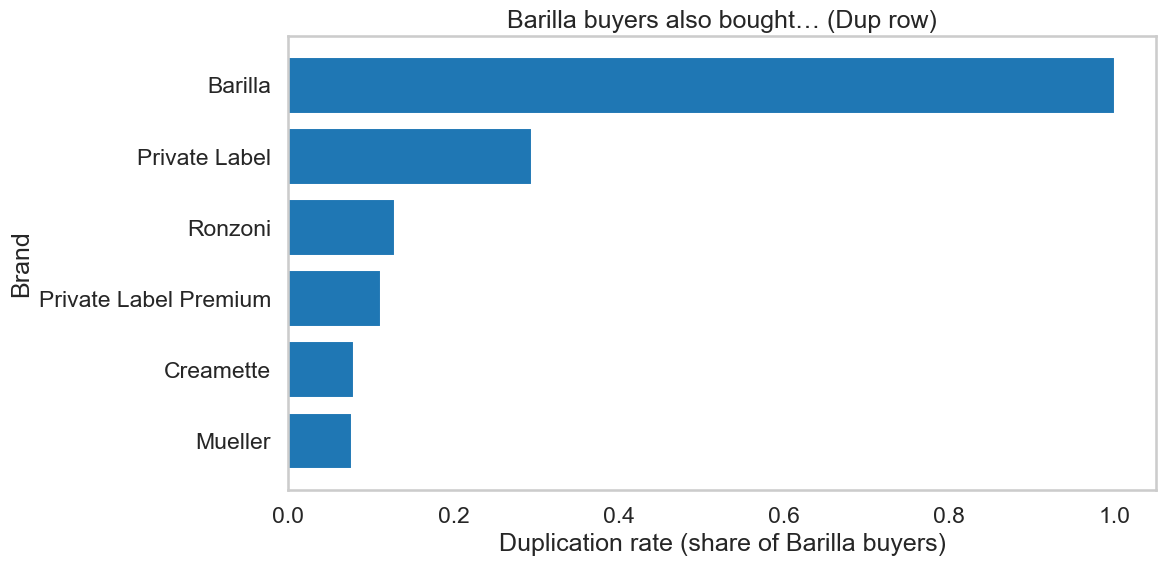

In [132]:
# 1) Build household sets per brand (buyers of each brand)
#    H_b = set of households who bought brand b at least once in the quarter.
FOCAL = "Barilla"
brand_hh = {b: set(g["household"]) for b, g in df_pasta_last_q.groupby("brand")}
brands = sorted(brand_hh.keys())

# 2) Duplication-of-purchase matrix

dup = pd.DataFrame(index=brands, columns=brands, dtype=float)

for i in brands:
    Hi = brand_hh[i]
    ni = len(Hi)
    if ni == 0:
        dup.loc[i, :] = 0.0
        continue
    for j in brands:
        dup.loc[i, j] = len(Hi & brand_hh[j]) / ni

# Make sure it’s nicely ordered
dup = dup.sort_index(axis=0).sort_index(axis=1)


# 3) Barilla’s overlap row: who Barilla buyers also bought
barilla_dup = dup.loc[FOCAL].sort_values(ascending=False)
barilla_dup.name = f"Dup({FOCAL} → j)"

print("Barilla overlaps most with (top 10):")
print(barilla_dup.head(10).round(3))


# 4) (Optional) sanity check vs brand volume shares (Dirichlet-style)
vol_share = (df_pasta_last_q.groupby("brand")["units"].sum() / df_pasta_last_q["units"].sum()).reindex(dup.columns)
dup_fit_mae = (dup.sub(vol_share, axis=1).abs().stack().mean())
print(f"\nDuplication vs volume-share MAE (lower ≈ closer to Dirichlet expectation): {dup_fit_mae:.4f}")


# 5) (Optional) export for slides
dup.to_csv("/Users/ying/25001197/assignment_2 copy/outputs/duplication_matrix_last_quarter.csv", index=True)
barilla_dup.to_csv("/Users/ying/25001197/assignment_2 copy/outputs/barilla_duplication_row_last_quarter.csv", header=["dup_rate"])


# 6) (Optional) quick visual: top overlaps for Barilla
topk = 6
top_barilla = barilla_dup.head(topk)

plt.figure(figsize=(12,6))
plt.barh(top_barilla.index[::-1], top_barilla.values[::-1])
plt.title(f"{FOCAL} buyers also bought… (Dup row)")
plt.xlabel("Duplication rate (share of Barilla buyers)")
plt.ylabel("Brand")
plt.tight_layout()
plt.grid(False)
plt.show()

## 4.6 Pricing in last quarter - competition

/var/folders/_d/xcgr17q96l95x2dcnvhdt6sw0000gn/T/ipykernel_20464/2674877219.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=ordered_brands, showfliers=False)  # hide extreme dots for clarity


<Figure size 640x480 with 0 Axes>

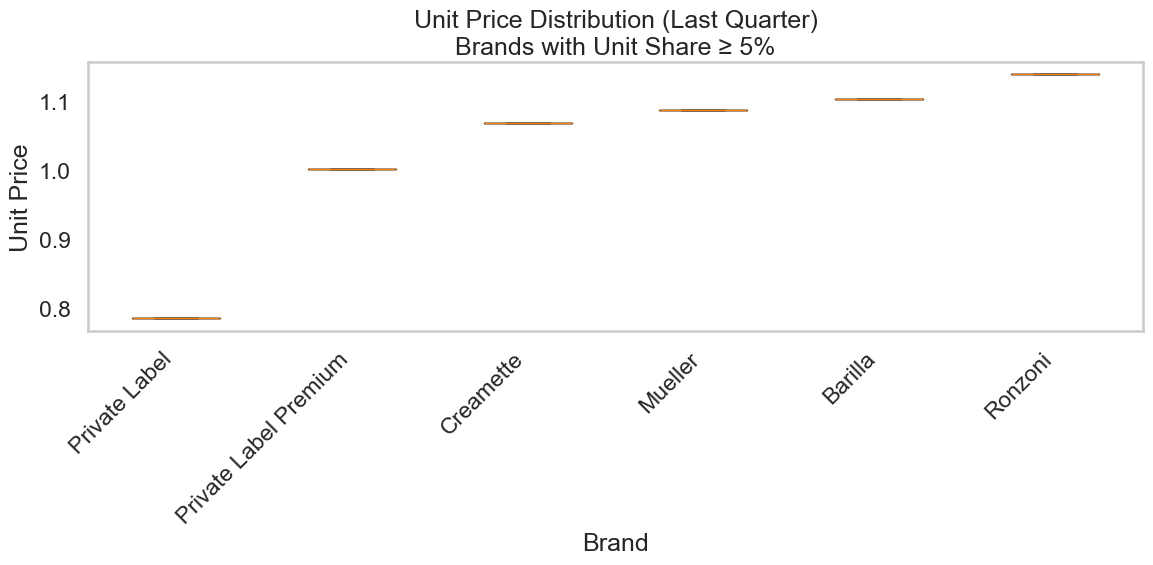

In [141]:
# 1) Compute market share by units (in last quarter)
brand_units = df_pasta_last_q.groupby("brand")["units"].sum()
unit_share = (brand_units / brand_units.sum()).sort_values(ascending=False)

# 2) Keep brands with share >= 0.05
keep_brands = unit_share[unit_share >= 0.05].index.tolist()

# (optional) ensure enough price observations per brand (e.g., at least 30)
min_obs = 30
brand_counts = df_pasta_last_q.groupby("brand")["unit_price"].size()
keep_brands = [b for b in keep_brands if brand_counts.get(b, 0) >= min_obs]

# 3) Order brands by median unit price (nice for visual reading)
med_price = df_pasta_last_q[df_pasta_last_q["brand"].isin(keep_brands)].groupby("brand")["unit_price"].median()
ordered_brands = med_price.sort_values().index.tolist()

# 4) Prepare data for boxplot
data = [df_pasta_last_q.loc[df_pasta_last_q["brand"]==b, "unit_price"].values for b in ordered_brands]

# 5) (optional) clip extreme outliers to reduce axis stretch
#    Comment out if you want raw distributions.
def clip_outliers(x, q1=0.01, q99=0.99):
    lo, hi = np.quantile(x, [q1, q99])
    return x[(x >= lo) & (x <= hi)]
data = [clip_outliers(x) for x in data]

# 6) Plot: one chart, no custom colors/styles (per your course rules)
plt.figure(figsize=(12,6))
plt.boxplot(data, labels=ordered_brands, showfliers=False)  # hide extreme dots for clarity
plt.title("Unit Price Distribution (Last Quarter)\nBrands with Unit Share ≥ 5%")
plt.xlabel("Brand")
plt.ylabel("Unit Price")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(False)
plt.show()

# 7) (optional) Save for slides
plt.savefig("/Users/ying/25001197/assignment_2 copy/outputs/figs/unit_price_boxplot_top_brands_last_q.png", dpi=200, bbox_inches="tight")

## 4.7 RFM segmentation

In [138]:
# DEFINE FUNCTIONS

def load_data():
    try:
        #data = df_pasta_last_q
        data = df_pasta
        print("\nData loaded successfully!")
        return data
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def rfm_analysis(data):
    # Filter for the most recent one year of data
    current_day = data['day'].max()
    one_year_ago = current_day - 365
    filtered_data = data[data['day'] >= one_year_ago]

    # RFM Analysis
    rfm_df = filtered_data.groupby('household').agg({
        'day': lambda x: current_day - x.max(),  # Recency: Days since last purchase
        'dollar_sales': 'sum',  # Monetary Value: Total revenue per customer
        'basket': 'nunique'  # Frequency: Count unique purchase occasions per customer
    }).rename(columns={
        'day': 'Recency',
        'dollar_sales': 'MonetaryValue',
        'basket': 'Frequency'
    })

    return rfm_df


def create_rfm_bins(rfm_df, n_bins):
    # Add a tiny noise to handle duplicates
    rfm_df['Recency'] += np.random.normal(0, 1e-6, len(rfm_df))
    rfm_df['Frequency'] += np.random.normal(0, 1e-6, len(rfm_df))
    rfm_df['MonetaryValue'] += np.random.normal(0, 1e-6, len(rfm_df))
    
    rfm_df['RecencyBin'] = pd.qcut(rfm_df['Recency'], n_bins, labels=range(1, n_bins + 1), duplicates='drop')
    rfm_df['FrequencyBin'] = pd.qcut(rfm_df['Frequency'], n_bins, labels=range(1, n_bins + 1), duplicates='drop')
    rfm_df['MonetaryBin'] = pd.qcut(rfm_df['MonetaryValue'], n_bins, labels=range(1, n_bins + 1), duplicates='drop')
    
    return rfm_df

def save_data(data, output_file_path):
    if not output_file_path.endswith('.csv'):
        output_file_path += '.csv'
    data.to_csv("/Users/ying/25001197/assignment_2 copy/outputs/rfm_pasta.csv", index=False)
    print(f"Data saved successfully to {output_file_path}")

data = load_data()
    
# Perform RFM analysis
rfm_df = rfm_analysis(data)

# Bin RFM variables if the user wants
rfm_df = create_rfm_bins(rfm_df, 3)
rfm_df.to_csv("/Users/ying/25001197/assignment_2 copy/outputs/rfm_df.csv", index=False)
rfm_df.head()


Data loaded successfully!


,Recency,MonetaryValue,Frequency,RecencyBin,FrequencyBin,MonetaryBin
household,,,,,,
1,8.329102e-07,1.000002,1.000000,1,1,1
2,9.999998e+00,59.640001,32.000001,1,3,3
4,1.440000e+02,1.270001,2.000000,2,2,1
10,3.150000e+02,1.280000,1.000000,3,1,1
12,8.000000e+01,1.550000,1.999999,2,2,1


## 4.8 Create profiles

In [143]:
# keep only numeric R/F/M rows
rfm_num = (
    rfm_df[['Recency','Frequency','MonetaryValue']]
    .astype('float32')
    .dropna()
)
print("Rows used:", len(rfm_num))

k = 3  # the elbow appears at k=3
# when k = 6, Silhouette score: 0.4
# when k = 5, Silhouette score: 0.44
# when k = 4, Silhouette score: 0.46
# when k = 3, Silhouette score: 0.46
# when k = 2, Silhouette score: 0.41

scaler = StandardScaler()
X = scaler.fit_transform(rfm_num.values)

mbkm = MiniBatchKMeans(
    n_clusters=k,
    batch_size=2048,
    max_iter=100,
    n_init=5,
    random_state=42,
    reassignment_ratio=0.01
)
labels = mbkm.fit_predict(X)

#score = silhouette_score(X, labels)
#print("Silhouette score:", score)

# attach labels back to the aligned rfm_df
rfm_work = rfm_df.loc[rfm_num.index].copy()
rfm_work['Cluster'] = labels
rfm_work.head()

Rows used: 301369


,Recency,MonetaryValue,Frequency,RecencyBin,FrequencyBin,MonetaryBin,Cluster
household,,,,,,,
1,8.329102e-07,1.000002,1.000000,1,1,1,2
2,9.999998e+00,59.640001,32.000001,1,3,3,0
4,1.440000e+02,1.270001,2.000000,2,2,1,2
10,3.150000e+02,1.280000,1.000000,3,1,1,1
12,8.000000e+01,1.550000,1.999999,2,2,1,2


In [144]:
centers_scaled = mbkm.cluster_centers_
centers = pd.DataFrame(
    scaler.inverse_transform(centers_scaled),
    columns=['Recency','Frequency','MonetaryValue']
)
centers.index.name = 'Cluster'
centers

,Recency,Frequency,MonetaryValue
Cluster,,,
0,37.396671,10.506873,16.572979
1,252.933472,1.467822,2.062518
2,72.337845,2.564920,3.397258


In [145]:
def mode_int(s): 
    # most frequent value; for ties, smallest value wins naturally
    return s.value_counts().index[0]

profile = (
    rfm_work
    .groupby('Cluster')
    .agg(
        Recency_mean=('Recency','mean'),
        Frequency_mean=('Frequency','mean'),
        Monetary_mean=('MonetaryValue','mean'),
        RecencyBin_mode=('RecencyBin', mode_int),
        FrequencyBin_mode=('FrequencyBin', mode_int),
        MonetaryBin_mode=('MonetaryBin', mode_int),
        Count=('Cluster','size')
    )
    .sort_index()
)
profile

,Recency_mean,Frequency_mean,Monetary_mean,RecencyBin_mode,FrequencyBin_mode,MonetaryBin_mode,Count
Cluster,,,,,,,
0,36.008321,11.156139,17.787653,1,3,3,38216
1,250.632229,1.471278,2.083042,3,1,1,103056
2,69.881959,2.734736,3.647487,2,2,2,160097


<Figure size 640x480 with 0 Axes>

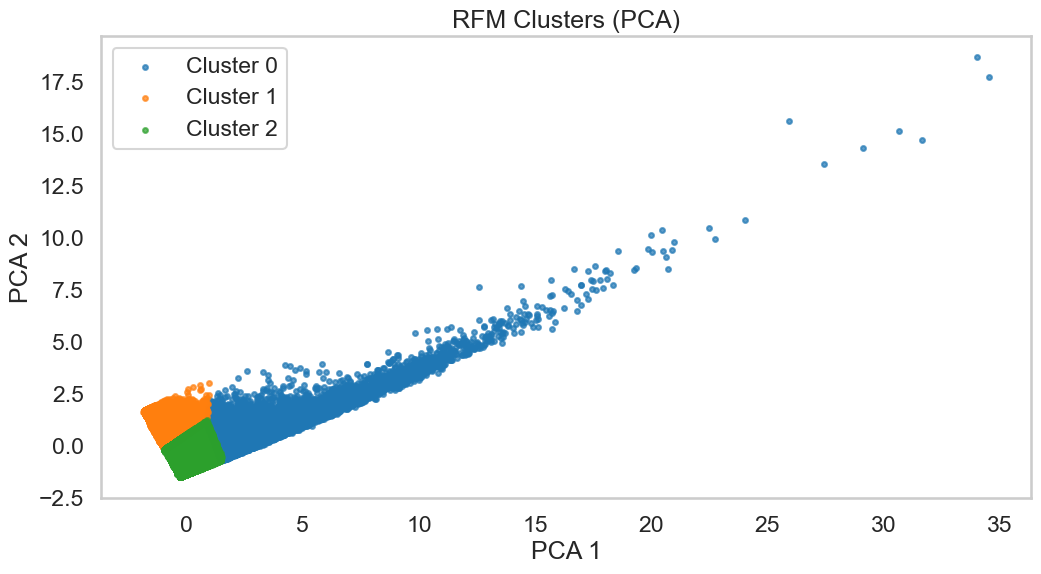

In [146]:
# PCA analysis to reduce dimensions
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(12,6))
for c in range(k):
    idx = (labels == c)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=12, alpha=0.7, label=f'Cluster {c}')
plt.xlabel('PCA 1'); plt.ylabel('PCA 2'); plt.title('RFM Clusters (PCA)')
plt.legend()
plt.grid(False)

plt.savefig("/Users/ying/25001197/assignment_2 copy/outputs/figs/RFM_Clusters(PCA).png", dpi=300, bbox_inches="tight")
plt.show()

# 6) Dirichlet Model fitting

## 6.1 Classify - two groups in total (market share>=5% & market share<5%)

In [147]:
# Sanity checks
req = {"brand","household","basket","units","dollar_sales"}
missing = req - set(df_pasta_last_q.columns)
assert not missing, f"Missing columns: {missing}"
print("Rows in Q8:", len(df_pasta_last_q), "| Unique brands:", df_pasta_last_q["brand"].nunique())

share_basis = "units"

brand_units_totals = (df_pasta_last_q.groupby("brand")[share_basis]
                  .sum()
                  .reset_index(name="brand_units_totals")
                  .sort_values("brand_units_totals", ascending=False))
brand_units_totals.head()

units_total = df_pasta_last_q["units"].sum()
print("units_total = ", units_total)

brand_units_totals["market_share"] = brand_units_totals["brand_units_totals"] / units_total
print(brand_units_totals.head(6)) # whose market share >= 5%

others_brands = brand_units_totals.loc[brand_units_totals["market_share"] < 0.05, "brand"].unique()
print("Others brands count (<5%):", len(others_brands))
print("Examples:", list(others_brands)[:10])

Rows in Q8: 286341 | Unique brands: 39
units_total =  363025
                    brand  brand_units_totals  market_share
30          Private Label              174062      0.479477
2                 Barilla               45359      0.124947
35                Ronzoni               27933      0.076945
7               Creamette               26793      0.073805
31  Private Label Premium               26324      0.072513
25                Mueller               25830      0.071152
Others brands count (<5%): 33
Examples: ['Barilla Plus', 'No Yolks', 'San Giorgio', 'Hodgson Mills', 'Private Label Value', 'Dreamfield', 'DaVinci', 'Dececco', 'Al Dente', 'Mrs Weiss']


In [148]:
others_df = df_pasta_last_q[df_pasta_last_q["brand"].isin(others_brands)].copy()

print("total pasta buyers: ", total_pasta_buyers)

buyers_others = others_df["household"].nunique()

tx_cat = df_pasta_last_q["basket"].nunique()
tx_others = others_df["basket"].nunique()

# b - penetration and w - purchase frequency (among Others buyers)
b_others = (buyers_others / total_pasta_buyers) if total_pasta_buyers else 0.0
w_others = (tx_others / buyers_others) if buyers_others else 0.0

print({"total_pasta_buyers": total_pasta_buyers, "buyers_others": buyers_others, 
       "tx_cat": tx_cat, "tx_others": tx_others,
       "b_others": round(b_others,4), "w_others": round(w_others,4)})

others_buyers = others_df["household"].unique()

# Category occasions for those buyers
cat_tx_by_hh = (df_pasta_last_q[df_pasta_last_q["household"].isin(others_buyers)]
                .groupby("household")["basket"].nunique()
                .rename("cat_tx_hh"))

# Others occasions for those buyers
others_tx_by_hh = (others_df.groupby("household")["basket"]
                   .nunique()
                   .rename("others_tx_hh"))
# SCR = brand units / total category units by that brand's buyers
scr_df = pd.concat([cat_tx_by_hh, others_tx_by_hh], axis=1).fillna(0)

# Pooled SCR (recommended headline)
SCR = (scr_df["others_tx_hh"].sum() / scr_df["cat_tx_hh"].sum()) if scr_df["cat_tx_hh"].sum() else 0.0

print({"SCR_pooled": round(SCR,4)})

brand_set_by_hh = (df_pasta_last_q.groupby("household")["brand"]
                   .apply(lambda s: set(s.unique())))
brand_set_others_buyers = brand_set_by_hh.loc[brand_set_by_hh.index.isin(others_buyers)]

others_set = set(others_brands)
sole_mask = brand_set_others_buyers.apply(lambda s: s.issubset(others_set))
sole_loyalty = (sole_mask.sum() / buyers_others) if buyers_others else 0.0

print({"sole_loyalty": round(sole_loyalty,4)})

units_others = others_df["units"].sum()
units_cat    = cat_df["units"].sum()

ms_vol_others = (units_others / units_cat) if units_cat else 0.0

results = {
    "others_brands_count": int(len(others_brands)),
    "b_others": float(b_others),
    "w_others": float(w_others),
    "SCR_pooled": float(SCR),
    "sole_loyalty": float(sole_loyalty),
    "ms_vol_others": float(ms_vol_others)
}
results

total pasta buyers:  411502
{'total_pasta_buyers': 411502, 'buyers_others': 22238, 'tx_cat': 239957, 'tx_others': 28475, 'b_others': 0.054, 'w_others': 1.2805}
{'SCR_pooled': np.float64(0.567)}
{'sole_loyalty': np.float64(0.4217)}


{'others_brands_count': 33,
 'b_others': 0.05404104961822786,
 'w_others': 1.2804658692328448,
 'SCR_pooled': 0.5669825972681295,
 'sole_loyalty': 0.4217105854843061,
 'ms_vol_others': 0.10116107706080849}